In [1]:
# encoding=utf-8
import os
import time
import re
import unicodedata
import traceback
import warnings
from typing import Callable
import importlib

from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fontTools.ttLib import TTFont

In [2]:
import utils
importlib.reload(utils)

from utils import fetch_font, LOG_DIRECTORY, LOG_SUFFIX, COLUMN_SEPARATOR, LogFile

In [3]:
fonts_dir = 'fonts'
font_size = 64
os.path.exists(fonts_dir)

True

In [4]:
font_list = []
file_list = os.listdir(fonts_dir)
for filename in file_list:
    child_path = os.path.join(fonts_dir, filename)

    if not os.path.isfile(child_path):
        warnings.warn(f'Skipping directory {child_path}!')
        continue

    file_ext = os.path.splitext(filename)[1]
    file_ext = file_ext.lower()

    if (file_ext == '.ttf') or (file_ext == '.otf'):
        font = fetch_font(child_path, font_size=font_size)
        font_list.append(font)
    else:
        warnings.warn(f'Skipping unknown file type {child_path}!')
        continue

/home/shioko/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Skipping unknown file type fonts/readme.txt!


In [ ]:
font_list

In [ ]:
font = font_list[0]
font

In [7]:
image_size = 64

In [8]:
canvas_size = int(max(font.size*2, image_size))
canvas_size

128

In [9]:
canvas = Image.new('L', (canvas_size, canvas_size), color=0)
ctx = ImageDraw.Draw(canvas)

In [10]:
char_x = (canvas_size - font.size) / 2
char_y = (canvas_size - font.size) / 2
char_origin_pos = (char_x, char_y)
char_origin_pos

(32.0, 32.0)

In [11]:
c = 'あ'

In [12]:
ctx.text(
    xy=char_origin_pos,
    text=c,
    fill=255,
    font=font.font,
)

In [13]:
type(canvas)

PIL.Image.Image

In [14]:
canvas.save('sample_a.png', format='PNG')

In [15]:
np_img = np.asarray(canvas, dtype=np.uint8)
np_img.shape

(128, 128)

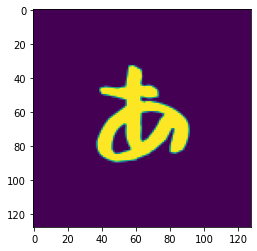

In [16]:
plt.imshow(np_img)

In [17]:
non_zeros_indices = np_img.nonzero()
type(non_zeros_indices)

tuple

In [18]:
len(non_zeros_indices)

2

In [19]:
len(non_zeros_indices[0])

1640

In [20]:
len(non_zeros_indices[1])

1640

In [21]:
non_zeros_indices

(array([33, 33, 33, ..., 89, 89, 89]), array([56, 57, 58, ..., 54, 55, 56]))

In [22]:
zero_ys, zero_xs = np_img.nonzero()[:2]  # `[:2]` just to be safe

min_x, max_x = min(zero_xs), max(zero_xs)
min_y, max_y = min(zero_ys), max(zero_ys)

# the character dimensions is caculated based on the nonzero pixels
character_width = max_x - min_x
character_height = max_y - min_y

min_x, max_x, min_y, max_y, character_width, character_height

(37, 91, 33, 89, 54, 56)

In [23]:
rgb_canvas = np.stack((np_img,)*3, axis=-1)
rgb_canvas.shape

(128, 128, 3)

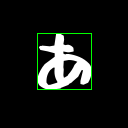

In [24]:
pil_image = Image.fromarray(rgb_canvas)
draw_obj = ImageDraw.Draw(pil_image)

draw_obj.rectangle(
    xy=[(min_x, min_y), (max_x, max_y)],
    outline=(0,255,0),
    width=1,
)

pil_image

In [25]:
pil_image.save('sample_a_with_bounding_box.png', format='PNG')

In [26]:
canvas_size - image_size

64

32 29


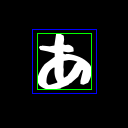

In [27]:
image_offset_top = min_y - int((image_size - character_height)/2)
image_offset_left = min_x - int((image_size - character_width)/2)

print(image_offset_left, image_offset_top)

draw_obj.rectangle(
    xy=[(image_offset_left, image_offset_top), (image_offset_left+image_size, image_offset_top+image_size)],
    outline=(0,0,255),
    width=1,
)

pil_image

In [28]:
pil_image.save('sample_a_with_bounding_boxes_for_exporting_image.png', 'PNG')

48.0 45.0


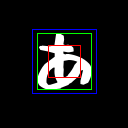

In [29]:
# experiment with image size smaller than font size
image_size = 32
image_offset_top = min_y - (image_size - character_height)/2
image_offset_left = min_x - (image_size - character_width)/2

print(image_offset_left, image_offset_top)

draw_obj.rectangle(
    xy=[(image_offset_left, image_offset_top), (image_offset_left+image_size, image_offset_top+image_size)],
    outline=(255,0,0),
    width=1,
)

pil_image

In [30]:
file_list = os.listdir(LOG_DIRECTORY)
file_list

['1586661863.311972-runtime.log',
 '1586662042.1526327-runtime.log',
 '1586662082.3868406-runtime.log',
 '1586662097.7665117-runtime.log',
 '1586676971.023995-runtime.log',
 '1586677160.823435-runtime.log',
 '1586691725.5852675-runtime.log',
 '1586691782.888618-runtime.log',
 '1586791139.7935503-runtime.log',
 '1586791220.6789849-runtime.log',
 '1586791258.085564-runtime.log',
 '1586791294.405975-runtime.log',
 '1586791367.6133404-runtime.log',
 '1586795362.6864376-runtime.log',
 '1586795381.2372532-runtime.log',
 '1586825108.9177797-runtime.log',
 '1586825384.5339162-runtime.log',
 '1586874051.136705-runtime.log']

In [52]:
logs = []

for filename in file_list:
    if not LOG_SUFFIX in filename:
        print(f'[WARNING] Skipping file {filename}.')
        continue

    filepath = os.path.join(LOG_DIRECTORY, filename)

    try:
        log_data = pd.read_csv(filepath, sep=COLUMN_SEPARATOR, names=('method_name', 'execution_time'))
    except:
        print(f'[WARNING] Skipping incompatible format {filename}!')
        continue

    ts = float(filename.replace(LOG_SUFFIX, ''))
    log_file = LogFile(filename, ts, log_data)
    logs.append(log_file)

logs.sort(key=lambda x: x.ts, reverse=True)

In [53]:
logs

[('2020-04-14_14-20-51', '1586874051.136705-runtime.log'),
 ('2020-04-14_00-49-44', '1586825384.5339162-runtime.log'),
 ('2020-04-14_00-45-08', '1586825108.9177797-runtime.log'),
 ('2020-04-13_16-29-41', '1586795381.2372532-runtime.log'),
 ('2020-04-13_16-29-22', '1586795362.6864376-runtime.log'),
 ('2020-04-13_15-22-47', '1586791367.6133404-runtime.log'),
 ('2020-04-13_15-21-34', '1586791294.405975-runtime.log'),
 ('2020-04-13_15-20-58', '1586791258.085564-runtime.log'),
 ('2020-04-13_15-20-20', '1586791220.6789849-runtime.log'),
 ('2020-04-13_15-18-59', '1586791139.7935503-runtime.log'),
 ('2020-04-12_11-43-02', '1586691782.888618-runtime.log'),
 ('2020-04-12_11-42-05', '1586691725.5852675-runtime.log'),
 ('2020-04-12_07-39-20', '1586677160.823435-runtime.log'),
 ('2020-04-12_07-36-11', '1586676971.023995-runtime.log'),
 ('2020-04-12_03-28-17', '1586662097.7665117-runtime.log'),
 ('2020-04-12_03-28-02', '1586662082.3868406-runtime.log'),
 ('2020-04-12_03-27-22', '1586662042.1526327-r

In [54]:
log = logs[0]
data = log.data
data

,method_name,execution_time
0,fetch_font,0.983982
1,fetch_font,0.712611
2,fetch_font,1.052044
3,fetch_font,0.128916
4,fetch_font,0.046987
5,fetch_font,0.042769
6,fetch_font,0.033545
7,fetch_font,0.088705
8,fetch_font,0.050754
9,fetch_font,0.070142


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb942784550>]],
      dtype=object)

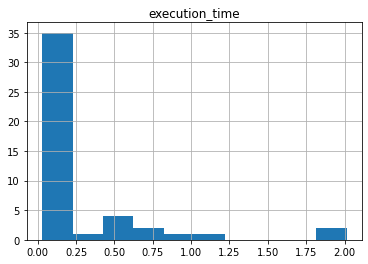

In [34]:
data.hist()

In [35]:
data.execution_time.sum()

13.030585527420044

In [36]:
np_data = data.to_numpy()
np_data

array([['fetch_font', 0.9839820861816406],
       ['fetch_font', 0.7126109600067139],
       ['fetch_font', 1.052043914794922],
       ['fetch_font', 0.12891554832458496],
       ['fetch_font', 0.04698705673217773],
       ['fetch_font', 0.04276895523071289],
       ['fetch_font', 0.03354501724243164],
       ['fetch_font', 0.08870506286621094],
       ['fetch_font', 0.05075383186340332],
       ['fetch_font', 0.07014226913452147],
       ['fetch_font', 0.1701488494873047],
       ['fetch_font', 0.07020306587219237],
       ['fetch_font', 0.05817413330078125],
       ['fetch_font', 0.04677557945251465],
       ['fetch_font', 0.09508037567138672],
       ['fetch_font', 0.059412717819213874],
       ['fetch_font', 0.7391214370727539],
       ['fetch_font', 0.24021100997924805],
       ['fetch_font', 0.08284235000610353],
       ['fetch_font', 0.06638693809509277],
       ['fetch_font', 0.10013699531555176],
       ['fetch_font', 0.03861093521118164],
       ['fetch_font', 0.0662791728973

In [37]:
np_data.shape

(46, 2)

In [38]:
for row in np_data:
    print(row)
    method_name, execution_time = row[:2]
    print(method_name, execution_time)
    break

['fetch_font' 0.9839820861816406]
fetch_font 0.9839820861816406


In [39]:
g = data.groupby('method_name')
g

In [40]:
execution_time_by_method_name = g.sum()
execution_time_by_method_name

,execution_time
method_name,
fetch_font,13.030586


In [41]:
execution_time_by_method_name

,execution_time
method_name,
fetch_font,13.030586


In [42]:
execution_time_by_method_name.to_numpy()

array([[13.03058553]])

# 3 plots

- Plot the total amount of time for each methods
- Plot the number of calls for each methods
- Plot max, min, and avg for each methods

In [43]:
func_data = {}

for row in np_data:
    func_name, exec_time = row[:2]
    if func_name in func_data:
        func_data[func_name]['num_calls'] += 1
        func_data[func_name]['total_exec_time'] += exec_time

        last_min = func_data[func_name]['min']
        func_data[func_name]['min'] = min(exec_time, last_min)

        last_max = func_data[func_name]['max']
        func_data[func_name]['max'] = max(exec_time, last_max)
    else:
        func_data[func_name] = {
            'num_calls': 1,
            'total_exec_time': exec_time,
            'min': exec_time,
            'max': exec_time,
        }

for func_name in func_data:
    # calculate and average
    total_exec_time = func_data[func_name]['total_exec_time']
    num_calls = func_data[func_name]['num_calls']

    func_data[func_name]['avg'] = total_exec_time / num_calls
    
func_data

{'fetch_font': {'num_calls': 46,
  'total_exec_time': 13.030585527420044,
  'min': 0.028693199157714844,
  'max': 2.0130846500396733,
  'avg': 0.28327359842217487}}

In [44]:
for key in func_data:
    print(key)

fetch_font


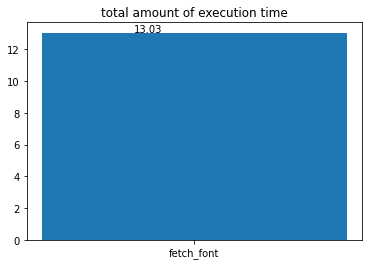

In [45]:
plt.title('total amount of execution time')
names = []
values = []
for func_name in func_data:
    names.append(func_name)
    values.append(func_data[func_name]['total_exec_time'])

bars = plt.bar(names, values)
# show values on top of bars
# https://stackoverflow.com/questions/53066633/python-how-to-show-values-on-top-of-bar-plot
text_height_delta = max(values) * .005
for idx, bar in enumerate(bars):
    y = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width()*0.3,
        y=bar.get_height() + text_height_delta,
        s=f'{values[idx]:.2f}',
    )

In [46]:
bars

<BarContainer object of 1 artists>

In [47]:
type(bars)

matplotlib.container.BarContainer

In [48]:
x = np.arange(8)
x

array([0, 1, 2, 3, 4, 5, 6, 7])

In [49]:
x * 2

array([ 0,  2,  4,  6,  8, 10, 12, 14])

# Experiment with printing with color to console

In [50]:
class TerminateColor:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'

In [51]:
print(f'{TerminateColor.HEADER}Header{TerminateColor.ENDC}')
print(f'{TerminateColor.OKBLUE}OKBLUE{TerminateColor.ENDC}')
print(f'{TerminateColor.OKGREEN}OKGREEN{TerminateColor.ENDC}')
print(f'{TerminateColor.WARNING}WARNING{TerminateColor.ENDC}')
print(f'{TerminateColor.FAIL}FAIL{TerminateColor.ENDC}')

Header
OKBLUE
OKGREEN
WARNING
FAIL


# Experiment with escaping invalid filename characters for using in regular expression

In [65]:
INVALID_FILENAME_CHARS = '`~!@#$%^&*,<>?\'":;|\\'
print(INVALID_FILENAME_CHARS)
print(repr(INVALID_FILENAME_CHARS))

`~!@#$%^&*,<>?'":;|\
'`~!@#$%^&*,<>?\'":;|\\'


In [64]:
print(INVALID_FILENAME_CHARS)

`~!@#$%^&*,<>?'":;|\


In [56]:
re.escape(INVALID_FILENAME_CHARS)

'\\`\\~\\!\\@\\#\\$\\%\\^\\&\\*\\,\\<\\>\\?\\\'\\"\\:\\;\\|\\\\'

In [57]:
x = '(){}[]'
repr(x)

"'(){}[]'"

In [58]:
x

'(){}[]'

In [59]:
len(x)

6

In [60]:
print(x)

(){}[]


# Experiment with TFRecord

In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.1.0'

In [6]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [7]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [14]:
feature = _float_feature(np.exp(1))

s = feature.SerializeToString()
s

b'\x12\x06\n\x04T\xf8-@'

In [15]:
type(s)

bytes

In [9]:
type(feature)

tensorflow.core.example.feature_pb2.Feature

In [10]:
feature_type = type(feature)
feature_type

tensorflow.core.example.feature_pb2.Feature

In [12]:
feature_type.mro()

[tensorflow.core.example.feature_pb2.Feature,
 google.protobuf.pyext._message.CMessage,
 google.protobuf.message.Message,
 object]

# Experiment with multiple decorators

Especially with built-in decorator `@classmethod`.

In [16]:
from functools import wraps

In [22]:
def timedecorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print('Hi from timedecorator!')
        print(f'calling {func.__name__}')
        retval = func(*args, **kwargs)
        return retval

    return wrapper

In [31]:
class Foo:
    i = 0

    @classmethod
    def foo(cls, *args, **kwargs):
        print('cls', type(cls), cls)
        print('cls.i', cls.i)
        print('args', type(args), args)
        print('kwargs', type(kwargs), kwargs)

In [32]:
Foo.foo('hi')

cls <class 'type'> <class '__main__.Foo'>
cls.i 0
args <class 'tuple'> ('hi',)
kwargs <class 'dict'> {}


In [37]:
class Bar:
    i = 2
    
    @classmethod
    @timedecorator
    def foo(cls, *args, **kwargs):
        print('cls', type(cls), cls)
        print('cls.i', cls.i)
        print('args', type(args), args)
        print('kwargs', type(kwargs), kwargs)

In [38]:
Bar.foo('hi')

Hi from timedecorator!
calling foo
cls <class 'type'> <class '__main__.Bar'>
cls.i 2
args <class 'tuple'> ('hi',)
kwargs <class 'dict'> {}


Put built-in decorator on first